In [22]:

'''

import image, scale
subsample image, generate rays
define standard optics
calculate paths, retinal image
define altered parameter range
calculate reverse paths
resample translated image, save


'''



In [2]:
## imports

# nd array manipulation
import numpy as np

from scipy import ndimage

# plotting with matplotlib, interactive notebook with jplot style
#%matplotlib notebook
%matplotlib widget
import matplotlib.pyplot as plt
#from jupyterthemes import jtplot; jtplot.style()

# 3d plotting toolkit
from mpl_toolkits.mplot3d import Axes3D

# colour mapping helpers
import matplotlib.colors as colors
import matplotlib.cm as cmx


In [3]:
# set auto reload imported modules tagged
%load_ext autoreload
%autoreload 2

# add custom python packages directory to path
import sys
sys.path.append('/home/brendan/dev/optics')

# import path tracing and image transformation engine
import optics


In [4]:
''' Generate Target Image '''

# set edge length
edge_len = 101

# generate pattern image (target)
test_image = optics.gen_image(edge_len)

# import image, scaled to edge length
#test_image = optics.import_image('./test-img-1.png', edge_len)


10201


In [5]:
''' Generate Initial Ray '''

# set height of target image (mm), and supersample factor
height = 5.
ss = 4.

# generate rays for image translation (list np.array[px, py, pz, vx, vy, vz] )
rays = optics.gen_img_rays(edge_len, height, ss)


401
160801


In [6]:
''' Define Standard Optics '''

# define standard optical parameters
opt_params = {
    'eye_front': 300.,
    
    'cornea_sph': 1.,
    'cornea_axis': 0.,
    
    'cornea_pow': np.sqrt(0.5),
    'cornea_f_rad': 7.8,
    'cornea_r_rad': 6.4,
    'cornea_thick': 0.6,
    'aqueous_thick': 3.0,
    
    'iris_dia': 4.,
    
    'lens_thick': 4.,
    'lens_f_rad_max': 10.1,
    'lens_f_rad_min': 5.95,
    'lens_r_rad_max': 6.1,
    'lens_r_rad_min': 4.5,
    
    'focus': 1.,
    
    'lens_pow': np.sqrt(4.5),
    
    'retina_thick': 17.2,
    'retina_rad': 12.5,
}

# generate standard optics chain
opts = optics.gen_optics(opt_params)


In [7]:
''' Calculate Ray Paths through Optics '''

# calculate ray paths through optics chain to retina
paths = optics.get_paths(rays, opts)


In [8]:
''' Generate Reverse Rays '''

# generate reverse rays for back propagation through reverse optics chain
back_rays = optics.gen_rev_rays(paths, opt_params)


In [149]:
''' Define Reverse Optics (Stigmatism) '''

#### UPDATE for delta params only

# define stigmatism optics chain by optical parameters
rev_opt_params = {
    'eye_front': 300.,
    
    'cornea_sph': 0.95,
    'cornea_axis': 0.,
    
    'cornea_pow': np.sqrt(0.5),
    'cornea_f_rad': 7.8,
    'cornea_r_rad': 6.4,
    'cornea_thick': 0.6,
    'aqueous_thick': 3.0,
    
    'iris_dia': 4.,
    
    'lens_thick': 4.,
    'lens_f_rad_max': 10.1,
    'lens_f_rad_min': 5.95,
    'lens_r_rad_max': 6.1,
    'lens_r_rad_min': 4.5,
    
    'focus': 1.,
    
    'lens_pow': np.sqrt(4.5),
    
    'retina_thick': 17.2,
    'retina_rad': 12.5,
}

# generate standard optics chain
rev_opts = optics.gen_optics_rev(rev_opt_params)


In [150]:
''' get ray paths through optics chain ''' 

# calculate reverse ray paths from retina, set initial refractive index
rev_paths = optics.get_paths(back_rays, rev_opts, n0 = 1.337)


In [151]:
''' Resample Translated Rays as Image'''

# get index of only rays that reach retina
j = [ i for i in range(len(paths)) if len(paths[i]) == 7 ]

# supersample image, get map of image pixel colour to each ray
img_map = ndimage.zoom(test_image, (((test_image.shape[0] - 1) * ss) + 1) / test_image.shape[0]).flatten()[j]

# get retinal image
#pts = np.stack([ path[-1][0] for path in rev_paths ])[:,1:]
pts = np.stack([ path[-1][0] for path in rev_paths ])[:,1:]


# calculate ray initial positions
rng = height / 2
# calculate step with subsample
stp = 2 * rng / ((edge_len - 1))


# define image ranges (pixel bins)
xs = np.arange(-rng, rng + stp, stp)[:]
ys = np.arange(-rng, rng + stp, stp)[:]

# generate empty image map
grid = np.zeros( (xs.shape[0],ys.shape[0]) )

# iterate over pixel bins
for i in range(len(xs)-1):
    for j in range(len(ys)-1):
        
        # get rays in pixel bin range
        k = np.where(
            (pts[:,0] >= xs[i]) &
            (pts[:,0] <= xs[i+1]) &
            (pts[:,1] >= ys[j]) &
            (pts[:,1] <= ys[j+1])
        )
        
        # average rays in pixel bin by image value
        if len(k[0]) > 0:
            #grid[j,i] = np.mean(img_map[k][:])
            grid[j,i] = np.median(img_map[k][:])


<IPython.core.display.Javascript object>


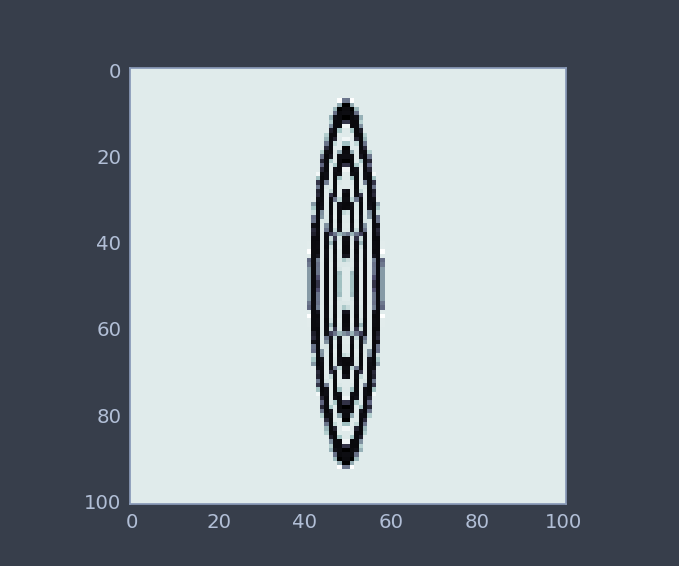

In [154]:
plt.figure(figsize = (6,5))

plt.subplot(111)
plt.grid()

plt.imshow(grid, cmap = 'bone_r')

#plt.savefig('./images/output-0s95.png', dpi = 200)

plt.show()

In [ ]:
''' Resample Translated Rays as Image'''

grid = translate_image(test_image, ss, paths, rev_paths, height, edge_len)


<IPython.core.display.Javascript object>


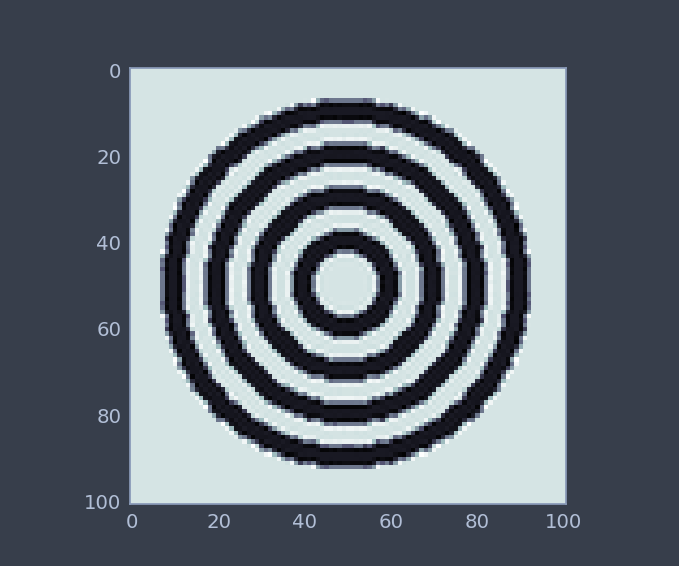

In [138]:
plt.figure(figsize = (6,5))

plt.subplot(111)
plt.grid()

plt.imshow(grid, cmap = 'bone_r')

#plt.savefig('./images/output-std.png', dpi = 200)

plt.show()

<IPython.core.display.Javascript object>


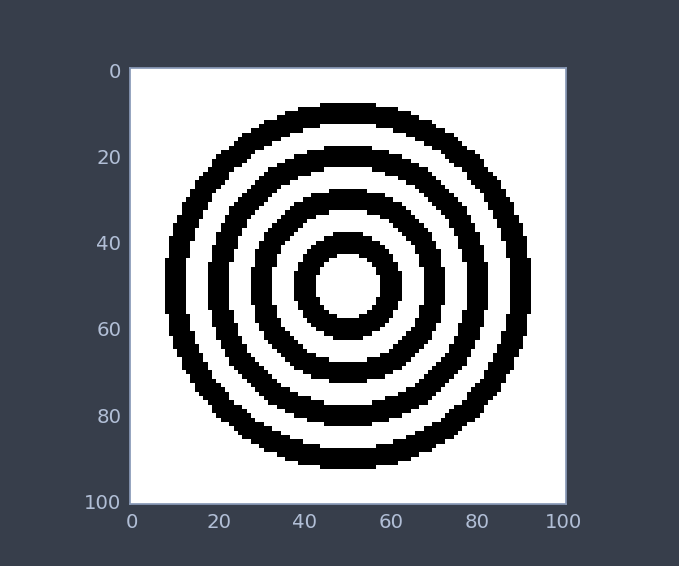

In [134]:
plt.figure(figsize = (6,5))

plt.subplot(111)
plt.grid()
plt.imshow(test_image, cmap = 'bone_r')

#plt.savefig('./images/input.png', dpi = 200)

plt.show()


<IPython.core.display.Javascript object>


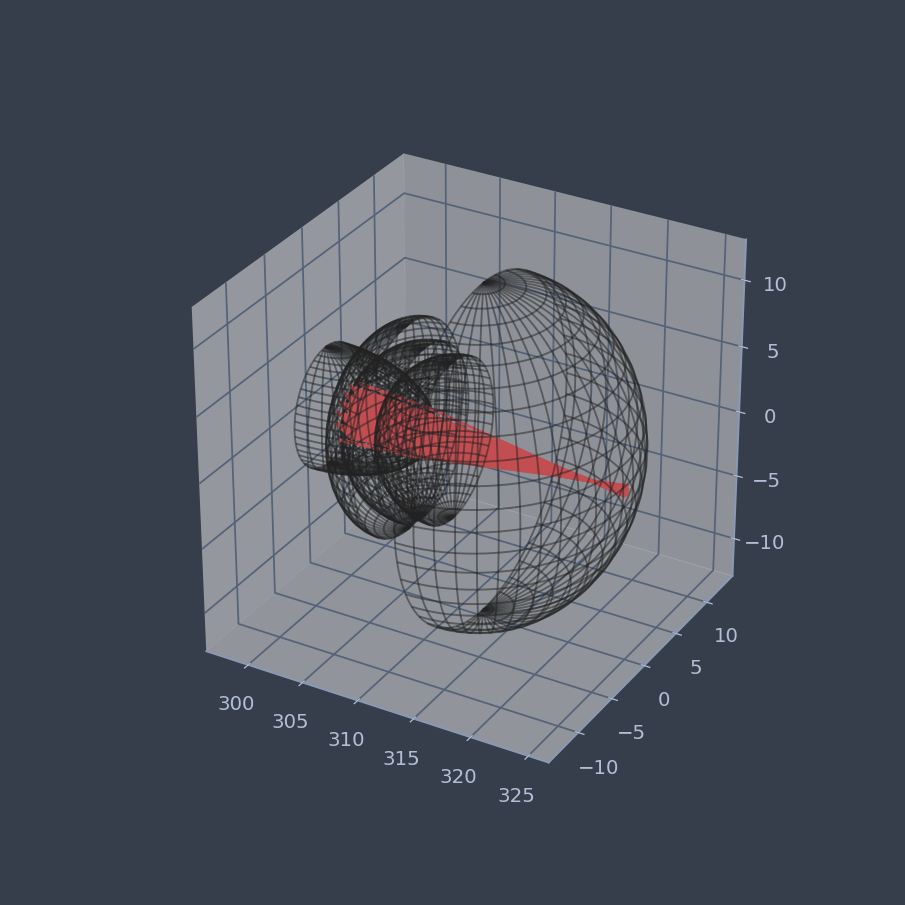

In [86]:
## plot ray paths

# initialise 3d figure
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(111, projection='3d')

#ax.set_xlim(0., 250.)
#ax.set_ylim(-15., 15.)
#ax.set_zlim(-15., 15.)


# plot all optics
if True:
    # iterate over each optic in chain
    for optic in opts[:]:
        
        # get optic parameters
        C = optic['centre']
        r = optic['radius']
        e = optic['scale']
        n2 = optic['opt_den']
        rev = optic['rev']

        # get optic points in 3d for plotting
        x, y, z = optics.plot_3d_ellipsoid(C, r, e, rev)
        # plot ellipsoid
        ax.plot_wireframe(x, y, z,  rstride = 2, cstride = 2, color = 'k', alpha = 0.5)


# iterate over each ray path
for i in range(len(paths))[::10]:
    
    # check for any refraction of ray with optics
    #if len(paths[i]) > 1:
    # only ray that hit retina
    if len(paths[i]) == 7:
        path = paths[i]
        
        # iterate ray path through optics
        for j in range(len(path)-1)[1:]:
            
            # plot path segment
            ax.plot([path[j][0][0], path[j+1][0][0]],
                    [path[j][0][1], path[j+1][0][1]],
                    [path[j][0][2], path[j+1][0][2]],
                    color = 'r', alpha = 0.7)

# format and display figure
plt.show()


<IPython.core.display.Javascript object>


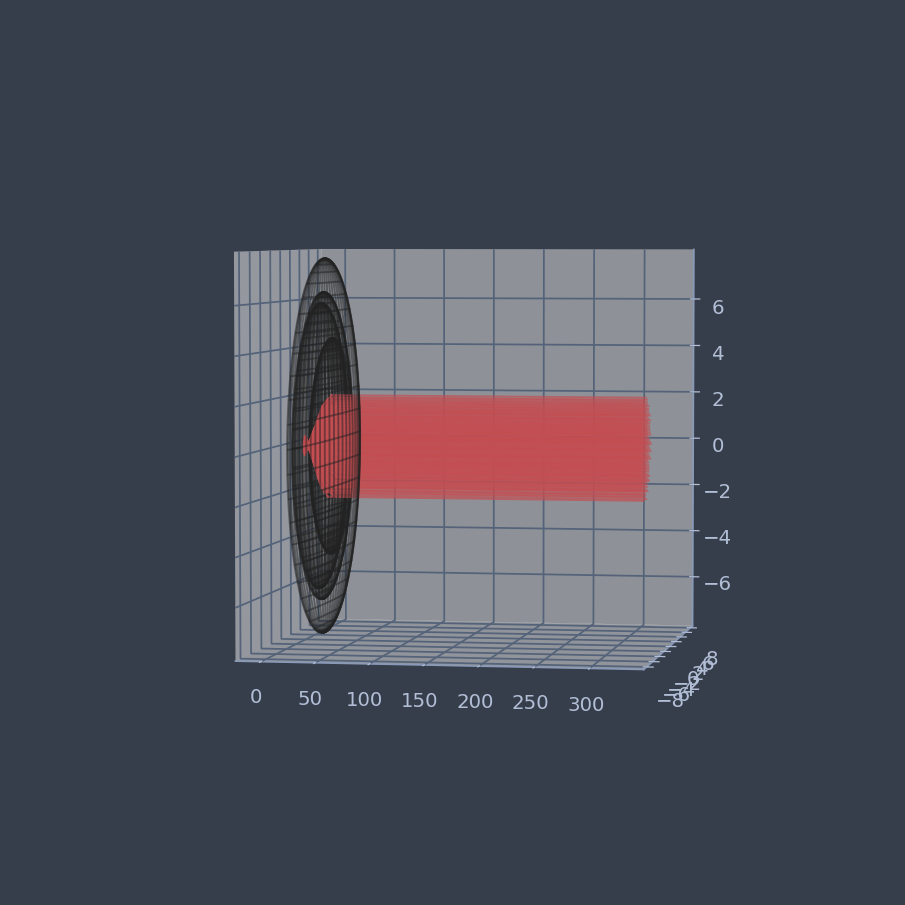

In [88]:
# initialise 3d figure
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(111, projection='3d')

#ax.set_xlim(0., 50.)
#ax.set_ylim(-15., 15.)
#ax.set_zlim(-15., 15.)


# plot all optics
if True:
    # iterate over each optic in chain
    for optic in rev_opts[:-1]:
        
        # get optic parameters
        C = optic['centre']
        r = optic['radius']
        e = optic['scale']
        n2 = optic['opt_den']
        rev = optic['rev']

        # get optic points in 3d for plotting
        x, y, z = optics.plot_3d_ellipsoid(C, r, e, rev)
        # plot ellipsoid
        ax.plot_wireframe(x, y, z,  rstride = 2, cstride = 2, color = 'k', alpha = 0.5)


# iterate over each ray path
for i in range(len(rev_paths))[::10]:
    
    # check for any refraction of ray with optics
    if len(paths[i]) > 1:
    # only ray that hit retina
    #if len(paths[i]) == 7:
        path = rev_paths[i]
        
        # iterate ray path through optics
        for j in range(len(path)-1)[:]:
            
            # plot path segment
            ax.plot([path[j][0][0], path[j+1][0][0]],
                    [path[j][0][1], path[j+1][0][1]],
                    [path[j][0][2], path[j+1][0][2]],
                    color = 'r', alpha = 0.7)

# format and display figure
plt.show()
